# Example 3: -  Including systematics

Johann Brehmer, Felix Kling, Kyle Cranmer 2018

In this tutorial we will demonstrate how to include systematics in a MadMiner analysis. As physics example, we will consider $ZH \to \mu\mu \tau\tau$ production at parton level, with smearing functions. 

## Preparations

Let us first load all the python libraries again

In [1]:
import sys
import os
madminer_src_path = "/Users/felixkling/Documents/GitHub/madminer"
sys.path.append(madminer_src_path)

from __future__ import absolute_import, division, print_function, unicode_literals

import logging
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
% matplotlib inline

from madminer.core import MadMiner
from madminer.plotting import plot_2d_morphing_basis
from madminer.sampling import combine_and_shuffle
from madminer.lhe import LHEProcessor
from madminer.sampling import SampleAugmenter
from madminer.plotting import plot_distributions

Please enter here the path to your MG5 root directory. This notebook assumes that you installed Delphes and Pythia through MG5. **This needs to be updated by the user**

In [2]:
mg_dir = '/Users/felixkling/work/MG5_aMC_v2_6_2'

MadMiner uses the Python `logging` module to provide additional information and debugging output. You can choose how much of this output you want to see by switching the level in the following lines to `logging.DEBUG` or `logging.WARNING`.

In [3]:
logging.basicConfig(
    format='%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s',
    datefmt='%H:%M',
    level=logging.INFO
)

for key in logging.Logger.manager.loggerDict:
    if "madminer" not in key:
        logging.getLogger(key).setLevel(logging.WARNING)

## 1. Setup

### 1a) Parameter Space

Let us first define the theory parameters. We are again using the `EWdim6` model 

In [4]:
miner = MadMiner()

miner.add_parameter(
    lha_block='dim6',
    lha_id=2,
    parameter_name='CWL2',
    morphing_max_power=2,
    parameter_range=(-100.,100.)
)
miner.add_parameter(
    lha_block='dim6',
    lha_id=3,
    parameter_name='CBL2',
    morphing_max_power=2,
    parameter_range=(-100.,100.)
)

21:05 madminer.core        INFO    Added parameter CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-100.0, 100.0))
21:05 madminer.core        INFO    Added parameter CBL2 (LHA: dim6 3, maximal power in squared ME: (2,), range: (-100.0, 100.0))


### 1b) Benchmarks

Define SM benchmarks by hand, and scan to find remaining benchmarks.

In [5]:
miner.add_benchmark( {'CWL2':0., 'CBL2':0.}, 'sm')

21:05 madminer.core        INFO    Added benchmark sm: CBL2 = 0.00e+00, CWL2 = 0.00e+00)


In [6]:
miner.set_morphing(
    include_existing_benchmarks=True,
    n_trials=1000,
    max_overall_power=2
)

21:05 madminer.core        INFO    Optimizing basis for morphing
21:05 madminer.core        INFO    Added benchmark sm: CWL2 = 0.00e+00, CBL2 = 0.00e+00)
21:05 madminer.core        INFO    Added benchmark morphing_basis_vector_1: CWL2 = -1.86e+01, CBL2 = 87.40)
21:05 madminer.core        INFO    Added benchmark morphing_basis_vector_2: CWL2 = -8.01e+01, CBL2 = -9.39e+01)
21:05 madminer.core        INFO    Added benchmark morphing_basis_vector_3: CWL2 = 74.03, CBL2 = 43.86)
21:05 madminer.core        INFO    Added benchmark morphing_basis_vector_4: CWL2 = -8.41e+01, CBL2 = 73.91)
21:05 madminer.core        INFO    Added benchmark morphing_basis_vector_5: CWL2 = 92.50, CBL2 = -3.53e+01)


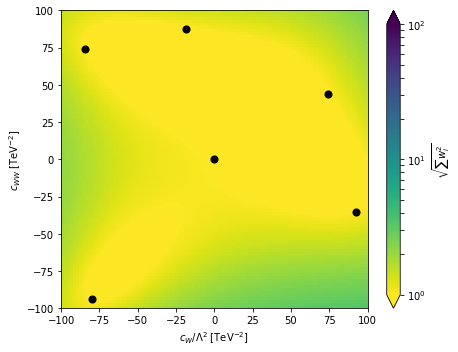

In [7]:
fig = plot_2d_morphing_basis(
    miner.morpher,
    xlabel=r'$c_{W} / \Lambda^2$ [TeV$^{-2}$]',
    ylabel=r'$c_{WW}} / \Lambda^2$ [TeV$^{-2}$]',
    xrange=(-100,100),
    yrange=(-100,100)
)

### 1c) Systematics

Systematics can be added using the `madminer.set_systematics()` command. In particular, we consider two sorts of systematics: scale variations and pdf variations. The setting is described by the following three inputs
- `scales`: Whether only the regularization scale (`"mur"`), only the factorization scale (`"muf"`), both simultanously with $\mu=\mu_F=\mu_R$ (`"together"`) or both independently (`"independent"`) are varied.
- `scale_variation`: If not `None`, the regularization and / or factorization scales are varied. A tuple like ($\mu_{max},\mu_{min}$) specifies the factors with which they are varied. Here $\mu_{max}$ refers to the name of the benchmark with $\nu = 1$, while $\mu_{min}$ is either `None` or refers to the name of the benchmark with $\nu = -1$. Note that if more than two scales are given, currently only first and last scale are used.
- `pdf_variation`: If not `None`, the PDFs are varied. The option is passed along to the `--pdf` option of MadGraph's systematics module. See https://cp3.irmp.ucl.ac.be/projects/madgraph/wiki/Systematics for a list. For example, the option `"90900"` would run over all the eigenvectors of the PDF4LHC15_nlo_30 set. 

In [8]:
miner.set_systematics(
    scale_variation=(0.5,1,2), 
    scales="independent", 
    pdf_variation="90900"
)

### 1d) Save setup

In [9]:
miner.save('data/madminer_example.h5')

21:05 madminer.core        INFO    Saving setup (including morphing) to data/madminer_example.h5


## 2. Event Generation

Load MadMiner again

In [10]:
miner.load('data/madminer_example.h5')

21:05 madminer.core        INFO    Found 2 parameters:
21:05 madminer.core        INFO       CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-100.0, 100.0))
21:05 madminer.core        INFO       CBL2 (LHA: dim6 3, maximal power in squared ME: (2,), range: (-100.0, 100.0))
21:05 madminer.core        INFO    Found 6 benchmarks:
21:05 madminer.core        INFO       sm: CWL2 = 0.00e+00, CBL2 = 0.00e+00
21:05 madminer.core        INFO       morphing_basis_vector_1: CWL2 = -1.86e+01, CBL2 = 87.40
21:05 madminer.core        INFO       morphing_basis_vector_2: CWL2 = -8.01e+01, CBL2 = -9.39e+01
21:05 madminer.core        INFO       morphing_basis_vector_3: CWL2 = 74.03, CBL2 = 43.86
21:05 madminer.core        INFO       morphing_basis_vector_4: CWL2 = -8.41e+01, CBL2 = 73.91
21:05 madminer.core        INFO       morphing_basis_vector_5: CWL2 = 92.50, CBL2 = -3.53e+01
21:05 madminer.core        INFO    Found morphing setup with 6 components
21:05 madminer.core        INFO    Foun

We now run MadMiner for the signal: 

In [11]:
miner.run(
    mg_directory=mg_dir,
    mg_process_directory='./mg_processes/signal',
    log_directory='logs/signal',
    sample_benchmark='sm',
    proc_card_file='cards/proc_card_signal.dat',
    param_card_template_file='cards/param_card_signal.dat',
    run_card_file='cards/run_card.dat',
    pythia8_card_file=None,
    initial_command='source ~/.bashrc'
)

21:05 madminer.utils.inter INFO    Generating MadGraph process folder from cards/proc_card_signal.dat at ./mg_processes/signal
21:05 madminer.core        INFO    Run 0
21:05 madminer.core        INFO      Sampling from benchmark: sm
21:05 madminer.core        INFO      Original run card:       cards/run_card.dat
21:05 madminer.core        INFO      Original Pythia8 card:   None
21:05 madminer.core        INFO      Copied run card:         /madminer/cards/run_card_0.dat
21:05 madminer.core        INFO      Copied Pythia8 card:     None
21:05 madminer.core        INFO      Param card:              /madminer/cards/param_card_0.dat
21:05 madminer.core        INFO      Reweight card:           /madminer/cards/reweight_card_0.dat
21:05 madminer.core        INFO      Log file:                run_0.log
21:05 madminer.core        INFO    Creating param and reweight cards in ./mg_processes/signal//madminer/cards/param_card_0.dat, ./mg_processes/signal//madminer/cards/reweight_card_0.dat
21:05 ma

## 3. Extract Parton Level Observables / Weights 

### 3a) Setting up LHEProcessor 

We first initialize the the LHEProcessor and add the LHE file

In [12]:
lhep = LHEProcessor('data/madminer_example.h5')

lhep.add_sample(
    'mg_processes/signal/Events/run_01/unweighted_events.lhe.gz',
    sampled_from_benchmark="sm",
    k_factor=1.0
)

### 3b) Smearing Functions

Instead of performing a proper proper shower and detector simulation, we can simulate smearing effects at parton level smearing through smearing functions. Here we will assume a simple 10% uncertainty on the tau energy measurements and a $\pm 0.05$ smearing for tau $\eta$ and $\phi$. The transverse momenta of the taus are then derived from the smeared energy and the on-shell condition for the quarks (this is what `pt_resolution_abs=None` does). The leptons from the Z-boson decay are assumed to be measured perfectly (otherwise we'd have to call `set_smearing` another time with `pdgis=[-13 13]`).

In [13]:
lhep.set_smearing(
    pdgids=[-15, 15],   
    energy_resolution_abs=0.05,
    energy_resolution_rel=0,
    pt_resolution_abs=None,
    pt_resolution_rel=None,
    eta_resolution_abs=0.02,
    eta_resolution_rel=0,
    phi_resolution_abs=0.02,
    phi_resolution_rel=0,
)

### 3c) Add Observables and Cuts

We will now add some observables.  In the expression string, you can use the terms `j[i]`, `e[i]`, `mu[i]`, `tau[i]`,  `a[i]`, `met`, where the indices `i` refer to a ordering by the transverse momentum. In addition, you can use `p[i]`, which denotes the `i`-th particle in the order given in the LHE sample (which is the order in which the final-state particles where defined in MadGraph).

Here we on a small set of higher-level observables: 

In [14]:
lhep.add_observable('m_Z', '(mu[0]+mu[1]).m',required=True)
lhep.add_observable('m_H', '(tau[0]+tau[1]).m',required=True)
lhep.add_observable('m_ZH', '(mu[0]+mu[1]+tau[0]+tau[1]).m',required=True)
lhep.add_observable('pt_Z', '(mu[0]+mu[1]).pt',required=True)
lhep.add_observable('pt_H', '(tau[0]+tau[1]).pt',required=True)
lhep.add_observable('eta_Z', '(mu[0]+mu[1]).eta',required=True)
lhep.add_observable('eta_H', '(tau[0]+tau[1]).eta',required=True)
lhep.add_observable('dphi_mumu', 'mu[0].deltaphi(mu[1])',required=True)
lhep.add_observable('dphi_mupmum', 'p[0].deltaphi(p[1])',required=True)
lhep.add_observable('dphi_tata', 'tau[0].deltaphi(tau[1])',required=True)
lhep.add_observable('dphi_mupH', 'p[0].deltaphi(tau[0]+tau[1])',required=True)
lhep.add_observable('dphi_mumH', 'p[1].deltaphi(tau[0]+tau[1])',required=True)
lhep.add_observable('pt_mup', 'p[0].pt',required=True)
lhep.add_observable('pt_mum', 'p[1].pt',required=True)

We can also add cuts, again in parse-able strings. In addition to the objects discussed above, they can contain the observables. As example, we consider cuts on the invariant di-lepton / di-tau mass:

In [15]:
lhep.add_cut('m_Z > 86')
lhep.add_cut('m_Z < 96')
lhep.add_cut('(tau[0]+tau[1]).m > 120')
lhep.add_cut('(tau[0]+tau[1]).m < 130')

### 3d) Run and Save 

We can now run `analyse_samples` to calculate all observables from the LHE file(s) generated before, apply the smearing, and check which events pass the cuts:

In [16]:
lhep.analyse_samples() 

21:21 madminer.lhe         INFO    Analysing LHE sample mg_processes/signal/Events/run_01/unweighted_events.lhe.gz
21:22 madminer.utils.inter WARNING Found 27 negative weights in event. Weights: OrderedDict([(u'sm', 2.8012e-09), ('1', 2.842708e-09), ('2', 2.8542486e-09), ('3', 2.8542389e-09), ('4', 2.8595701e-09), ('5', 2.842708e-09), ('6', 2.8012e-09), ('7', 2.8214735e-09), ('8', 2.8214535e-09), ('9', 2.8542389e-09), ('10', 2.8012e-09), ('11', 2.7420408e-09), ('12', 2.7696779e-09), ('13', 2.7696498e-09), ('14', 2.8214535e-09), ('15', 2.7420407e-09), ('16', 2.842708e-09), ('17', 2.8542486e-09), ('18', 2.8542389e-09), ('19', 2.8595701e-09), ('20', 2.842708e-09), ('21', 2.8214735e-09), ('22', 2.8214535e-09), ('23', 2.8542389e-09), ('24', 2.8012e-09), ('25', 2.7420408e-09), ('26', 2.7696779e-09), ('27', 2.7696498e-09), ('28', 2.8214535e-09), ('29', 2.7420407e-09), ('30', 2.842708e-09), ('31', 2.8542486e-09), ('32', 2.8542389e-09), ('33', 2.8595701e-09), ('34', 2.842708e-09), ('35', 2.8012

Finally, let's save everything

In [17]:
lhep.save('data/madminer_lhedata_signal.h5')

### 3e) Plot Distributions

Let us now plot some distributions. This can also be done using the `plot_distributions` function. As before the function requires
- `filename`: the name of the file with the processed LHE data
- `parameter_points`: a list of benchmarks, which can either be specified by there name (such as `sm`) or manually (for example `np.array([0,1])`). 
- `line_labels`: names for the benchmarks
- `observables`: list of observables to be plotted (when `None`, all observables are plotted)
We can also plot the uncertainties using the option `uncertainties='nuisance'`. By default, the full uncertainy band using all considered nuicanse parameter is shown. To obtain the uncertainty, MadMiner created a set of `n_toys` (default 100) Monte Carlo sample distributions to estimate the 68% CL band. Additionally, MadMiner can also show a set of `N` of these Monte Carlo toy samples using the option `draw_nuisance_toys=N`. 

More options, in particular regarding plotting, can be found via the command `help(plot_distributions)`. 

21:24 madminer.sampling    INFO    Loading data from data/madminer_lhedata_signal.h5
21:24 madminer.sampling    INFO    Found 2 parameters
21:24 madminer.sampling    INFO    Found 33 nuisance parameters
21:24 madminer.sampling    INFO    Found 81 benchmarks, of which 6 physical
21:24 madminer.sampling    INFO    Found 14 observables
21:24 madminer.sampling    INFO    Found 84546 events
21:24 madminer.sampling    INFO    Found morphing setup with 6 components
21:24 madminer.sampling    INFO    Found nuisance morphing setup
21:24 madminer.plotting    WARNING Removed 4 / 84546 events with negative weights


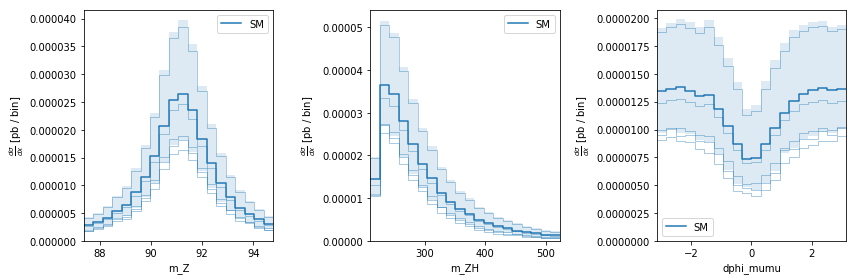

In [18]:
fig = plot_distributions(
    filename='data/madminer_lhedata_signal.h5',
    parameter_points=['sm'],
    line_labels=['SM'],
    observables=['m_Z','m_ZH','dphi_mumu'],
    uncertainties='nuisance',
    n_toys=100,
    n_bins=20,               
    normalize=False,  
    draw_nuisance_toys=5
)

We can also only consider a subset of nuisance parameter. In the following example, we separatly show the uncertainties from scale and PDF variations.  

21:25 madminer.sampling    INFO    Loading data from data/madminer_lhedata_signal.h5
21:25 madminer.sampling    INFO    Found 2 parameters
21:25 madminer.sampling    INFO    Found 33 nuisance parameters
21:25 madminer.sampling    INFO    Found 81 benchmarks, of which 6 physical
21:25 madminer.sampling    INFO    Found 14 observables
21:25 madminer.sampling    INFO    Found 84546 events
21:25 madminer.sampling    INFO    Found morphing setup with 6 components
21:25 madminer.sampling    INFO    Found nuisance morphing setup
21:25 madminer.plotting    WARNING Removed 4 / 84546 events with negative weights
21:25 madminer.sampling    INFO    Loading data from data/madminer_lhedata_signal.h5
21:25 madminer.sampling    INFO    Found 2 parameters
21:25 madminer.sampling    INFO    Found 33 nuisance parameters
21:25 madminer.sampling    INFO    Found 81 benchmarks, of which 6 physical
21:25 madminer.sampling    INFO    Found 14 observables
21:25 madminer.sampling    INFO    Found 84546 events
2

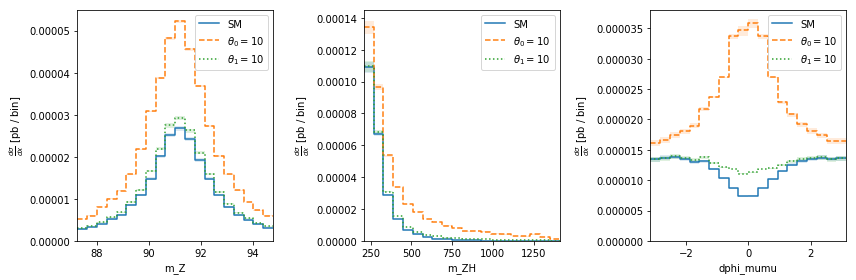

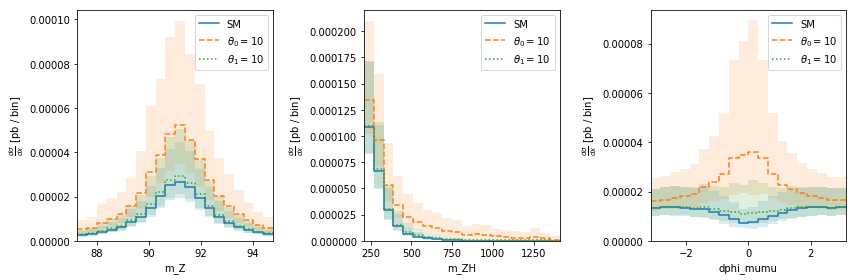

In [19]:
nuisance_scale=np.array([i for i in range(0,2)])
nuisance_pdf=np.array([i for i in range(2,33)])

fig_scale = plot_distributions(
     filename='data/madminer_lhedata_signal.h5',
    parameter_points=['sm',np.array([10,0]),np.array([0,10])],
    line_labels=['SM',r'$\theta_0=10$',r'$\theta_1=10$'],
    observables=['m_Z','m_ZH','dphi_mumu'],
    uncertainties='nuisance',
    n_bins=20,               
    normalize=False,  
    nuisance_parameters=nuisance_scale,
)

fig_pdf = plot_distributions(
     filename='data/madminer_lhedata_signal.h5',
    parameter_points=['sm',np.array([10,0]),np.array([0,10])],
    line_labels=['SM',r'$\theta_0=10$',r'$\theta_1=10$'],
    observables=['m_Z','m_ZH','dphi_mumu'],
    uncertainties='nuisance',
    n_bins=20,               
    normalize=False,  
    nuisance_parameters=nuisance_pdf,
)

Note that the uncertainty mainly effects the signal normalization, not the signal distribution. This can be seen looking at the normalized distributions via `normalize=True`

21:26 madminer.sampling    INFO    Loading data from data/madminer_lhedata_signal.h5
21:26 madminer.sampling    INFO    Found 2 parameters
21:26 madminer.sampling    INFO    Found 33 nuisance parameters
21:26 madminer.sampling    INFO    Found 81 benchmarks, of which 6 physical
21:26 madminer.sampling    INFO    Found 14 observables
21:26 madminer.sampling    INFO    Found 84546 events
21:26 madminer.sampling    INFO    Found morphing setup with 6 components
21:26 madminer.sampling    INFO    Found nuisance morphing setup
21:26 madminer.plotting    WARNING Removed 4 / 84546 events with negative weights


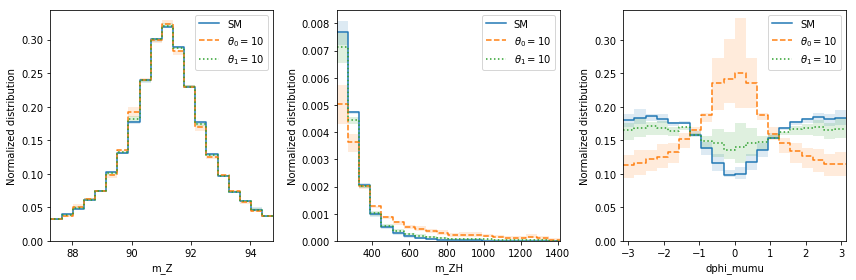

In [20]:
fig_pdf = plot_distributions(
     filename='data/madminer_lhedata_signal.h5',
    parameter_points=['sm',np.array([10,0]),np.array([0,10])],
    line_labels=['SM',r'$\theta_0=10$',r'$\theta_1=10$'],
    observables=['m_Z','m_ZH','dphi_mumu'],
    uncertainties='nuisance',
    n_bins=20,               
    normalize=True,  
)